<a href="https://colab.research.google.com/github/egagli/amath563/blob/main/labs/8/Lab_8_AMATH_Decomposition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Decompositions Examples

## Singular Value Decomposition (SVD)

In [2]:
#Calculate SVD
X = torch.rand(10, 20)
U, S, Vh = torch.linalg.svd(X)
V = Vh.T

#Low-dimensional Reconstruction
rd = 5 #Number of (reduced) dimensions to use
X_red = U[:, :rd]@(torch.diag(S)[:rd, :rd])@Vh[:rd, :]

## Principal Component Analysis (PCA)

In [3]:
#Calculate PCA
X = torch.rand(10, 20)
U, S, V = torch.pca_lowrank(X)

#Low-dimensional Reconstruction
rd = 5 #Number of (reduced) dimensions to use
X_red = U[:, :rd]@(torch.diag(S)[:rd, :rd])@V.T[:rd, :]

## Dynamic Mode Decomposition (DMD)

In [4]:
#DMD Calculation
X = torch.rand(10, 20)
X_a = X[:-1]
X_b = X[1:]

#Take SVD
U, S, Vh = torch.linalg.svd(X_a)
#Reduce Order
r = 3
U_r = U[:, :r]
V_r = Vh[:r, :].T
S_i = torch.inverse(torch.diag(S[:r]))
#Transform A
A_tilde = U_r.T@X_a@V_r@S_i
#Eigendocomposition of A
lam, W = torch.eig(A_tilde, True)
#Transform back, get DMD Modes
Phi = X_b@V_r@S_i@W

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:16: UserWarning: torch.eig is deprecated in favor of torch.linalg.eig and will be removed in a future PyTorch release.
torch.linalg.eig returns complex tensors of dtype cfloat or cdouble rather than real tensors mimicking complex tensors.
L, _ = torch.eig(A)
should be replaced with
L_complex = torch.linalg.eigvals(A)
and
L, V = torch.eig(A, eigenvectors=True)
should be replaced with
L_complex, V_complex = torch.linalg.eig(A) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:2910.)
  app.launch_new_instance()


#Clustering Methods

## K Means Clustering

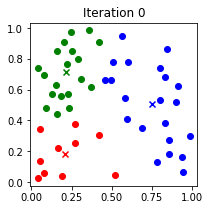

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

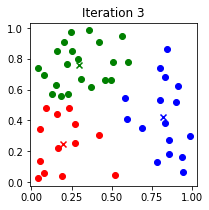

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

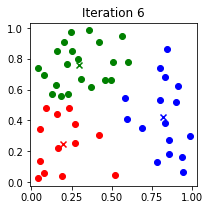

<Figure size 216x216 with 0 Axes>

<Figure size 216x216 with 0 Axes>

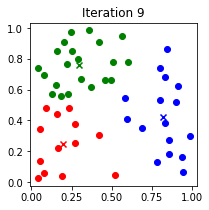

In [5]:
# K means clustering
x = torch.rand(50, 2)
K = 3 #Define K ahead of time
Niter = 10 # Defne number of mean update iterations
N, D = x.shape  # Number of samples, dimension of the ambient space

c = x[:K, :].clone()  # Simplistic initialization for the centroids

x_i = torch.Tensor(x.view(N, 1, D))  # (N, 1, D) samples
c_j = torch.Tensor(c.view(1, K, D))  # (1, K, D) centroids

for i in range(Niter):

  # E step: assign points to the closest cluster -------------------------
  D_ij = ((x_i - c_j) ** 2).sum(-1)  # (N, K) symbolic squared distances
  cl = D_ij.argmin(dim=1).long().view(-1)  # Points -> Nearest cluster

  # M step: update the centroids to the normalized cluster average: ------
  # Compute the sum of points per cluster:
  c.zero_()
  c.scatter_add_(0, cl[:, None].repeat(1, D), x)

  # Divide by the number of points per cluster:
  Ncl = torch.bincount(cl, minlength=K).type_as(c).view(K, 1)
  c /= Ncl  # in-place division to compute the average

  plt.figure(figsize = (3,3));
  if i%3 == 0:
    cs = ['r', 'g', 'b']
    for j in range(K):
      mask = cl == j
      plt.scatter(x[:, 0][mask], x[:,1][mask], c = cs[j]);
      plt.title(f'Iteration {i}')
      plt.scatter(c[j, 0], c[j, 1], c = cs[j], marker = 'x');

## K Nearest Neighbors

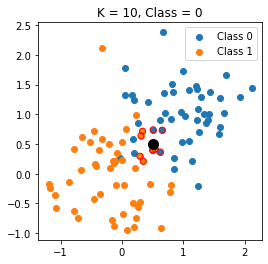

In [6]:
# K Nearest Neighbor
#Generate Two classes
data_0 = torch.normal(torch.zeros(50, 2), 0.5*torch.ones(50,2))
labels_0 = torch.zeros(50).long()
data_1 = torch.normal(torch.ones(50, 2), 0.5*torch.ones(50, 2))
labels_1 = torch.ones(50).long()

full_data = torch.vstack((data_0, data_1))
labels = torch.cat((labels_0, labels_1))
mask = labels.bool()

#Test Data Point
test_point = torch.Tensor([[0.5,0.5]])

#Find distances
K = 10
dist = torch.norm(test_point - full_data, dim = 1)
k_dists, k_idcs = torch.topk(dist, k =K,  largest = False)
label = torch.argmax(torch.bincount(labels[k_idcs]))

plt.figure(figsize = (4,4))

#Plot each class
for l in [0,1]:
  d_mask = mask!=bool(l)
  plt.scatter(full_data[d_mask][:,0], full_data[d_mask][:, 1], 
              label = f'Class {l}')
#Highlight K nearest neighbors
for k_idx in k_idcs:
  plt.scatter(full_data[k_idx, 0], full_data[k_idx, 1], 
              facecolors = 'none', edgecolors= 'r')
plt.scatter(test_point[:, 0], test_point[:, 1], c = 'k', s = 100)
plt.title(f'K = {K}, Class = {label}')
plt.legend()

# Example: Mall Customer Clustering

Source: https://www.kaggle.com/fazilbtopal/popular-unsupervised-clustering-algorithms/data

In [8]:
import pandas as pd
import seaborn as sns

import os
import warnings

warnings.filterwarnings('ignore')
#print(os.listdir("../input"))

In [9]:
df = pd.read_csv('Mall_Customers.csv')
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [10]:
df.rename(index=str, columns={'Annual Income (k$)': 'Income',
                              'Spending Score (1-100)': 'Score'}, inplace=True)
df.head()

,CustomerID,Gender,Age,Income,Score
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


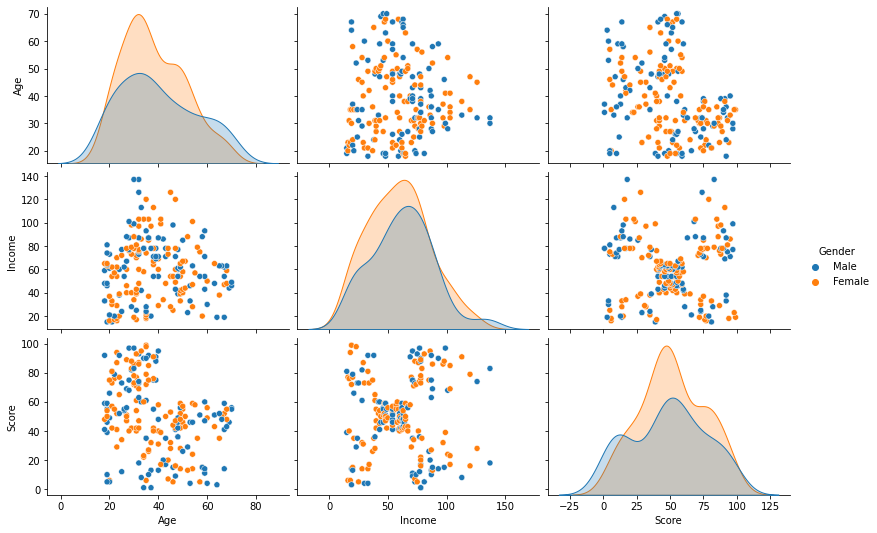

In [11]:
# Let's see our data in a detailed way with pairplot
X = df.drop(['CustomerID', 'Gender'], axis=1)
sns.pairplot(df.drop('CustomerID', axis=1), hue='Gender', aspect=1.5)
plt.show()

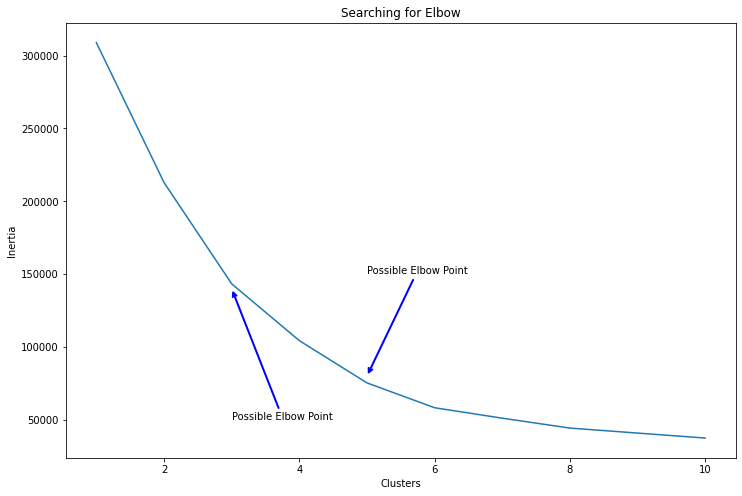

In [12]:
# For K means clustering, we can use sklearn.cluster.Kmeans

from sklearn.cluster import KMeans

clusters = []

for i in range(1, 11):
    km = KMeans(n_clusters=i).fit(X)
    clusters.append(km.inertia_)
    
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 11)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

# Annotate arrow
ax.annotate('Possible Elbow Point', xy=(3, 140000), xytext=(3, 50000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

ax.annotate('Possible Elbow Point', xy=(5, 80000), xytext=(5, 150000), xycoords='data',          
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3', color='blue', lw=2))

plt.show()

To select which value of k to use, we compare some loss function (here it is labelled inertia, which is the square distance from the centroid for each class) as a function of k. We are looking for an "elbow", where increasing k beyond that has a diminishing return. Here, we see that either k=3 or k=5 are good candidates.

## Visualizing Clusters

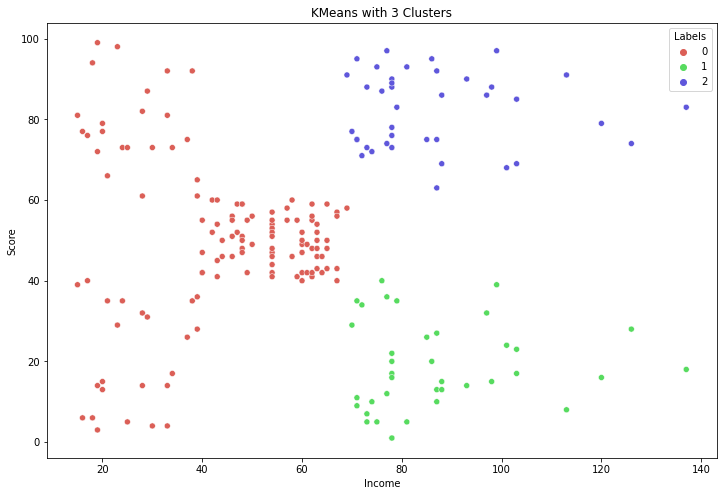

In [13]:
# 3 cluster
km3 = KMeans(n_clusters=3).fit(X)

X['Labels'] = km3.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(X['Income'], X['Score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 3))
plt.title('KMeans with 3 Clusters')
plt.show()

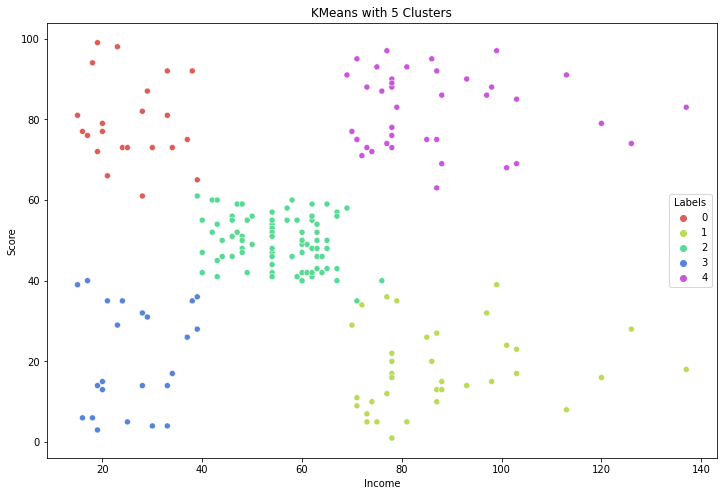

In [14]:
# Let's see with 5 Clusters
km5 = KMeans(n_clusters=5).fit(X)

X['Labels'] = km5.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(X['Income'], X['Score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 5))
plt.title('KMeans with 5 Clusters')
plt.show()

By judging from the plots we could say that 5 cluster seems better than the 3 ones. As this is a unsupervised problem we can't really know for sure which one is the best in real life but by looking at the data it's safe to say that 5 would be our choice.

We can analyze our 5 clusters in detail now:

Label 0 is low income and low spending \\
Label 1 is high income and high spending \\
Label 2 is mid income and mid spending \\
Label 3 is high income and low spending \\
Label 4 is low income and high spending

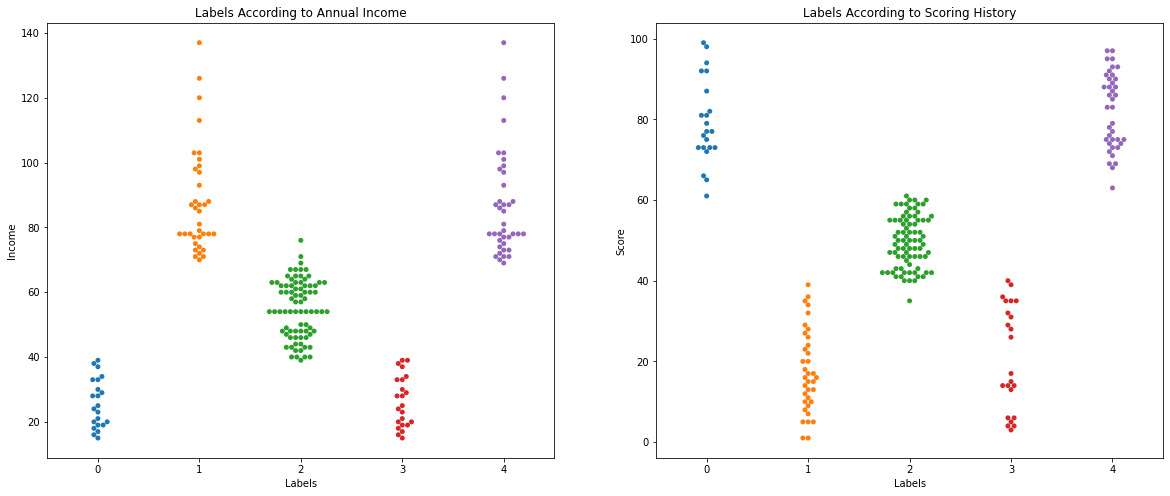

In [15]:
fig = plt.figure(figsize=(20,8))
ax = fig.add_subplot(121)
sns.swarmplot(x='Labels', y='Income', data=X, ax=ax)
ax.set_title('Labels According to Annual Income')

ax = fig.add_subplot(122)
sns.swarmplot(x='Labels', y='Score', data=X, ax=ax)
ax.set_title('Labels According to Scoring History')

plt.show()

# Assignment: Clustering and Classification of Credit Card Users

In [47]:
df = pd.read_csv('CC GENERAL.csv')
df = df.set_index('CUST_ID')
df = df.dropna()
df.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
CUST_ID,,,,,,,,,,,,,,,,,
C10001,40.900749,0.818182,95.40,0.00,95.40,0.000000,0.166667,0.000000,0.083333,0.00,0,2,1000.0,201.802084,139.509787,0.000000,12
C10002,3202.467416,0.909091,0.00,0.00,0.00,6442.945483,0.000000,0.000000,0.000000,0.25,4,0,7000.0,4103.032597,1072.340217,0.222222,12
C10003,2495.148862,1.000000,773.17,773.17,0.00,0.000000,1.000000,1.000000,0.000000,0.00,0,12,7500.0,622.066742,627.284787,0.000000,12
C10005,817.714335,1.000000,16.00,16.00,0.00,0.000000,0.083333,0.083333,0.000000,0.00,0,1,1200.0,678.334763,244.791237,0.000000,12
C10006,1809.828751,1.000000,1333.28,0.00,1333.28,0.000000,0.666667,0.000000,0.583333,0.00,0,8,1800.0,1400.057770,2407.246035,0.000000,12


When processing data with many different scales, you should normalize each dimension so that it has mean 0 and Variance 1.

## Your task
1. Normalize each dimension of the data and split into train set (8000) and test set (1000)


In [53]:
normalized_df = (df-df.mean())/df.std() # normalize with mean 0 and variance 1

In [54]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(normalized_df, test_size=0.1)

2. Use k-means clustering to separate the customers into k groups


In [58]:
# For K means clustering, we can use sklearn.cluster.Kmeans
from sklearn.cluster import KMeans

clusters = []

for i in range(1, 20):
    km = KMeans(n_clusters=i).fit(train)
    clusters.append(km.inertia_)

3. Find the "elbow" of the intertia vs. k plot to find the best value of k

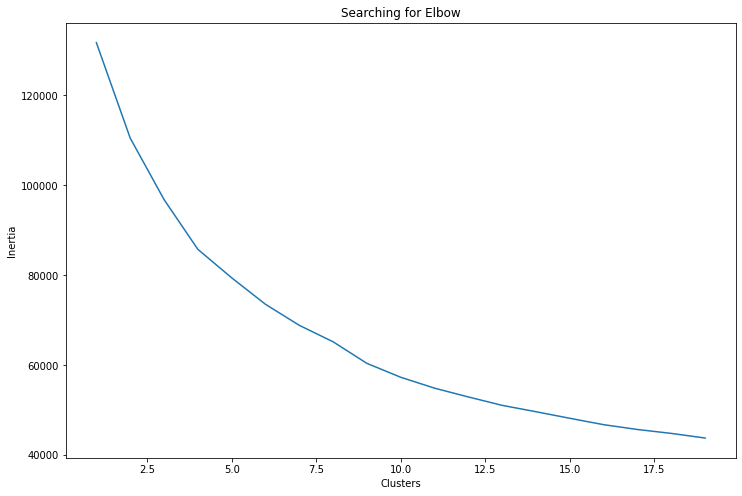

In [59]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.lineplot(x=list(range(1, 20)), y=clusters, ax=ax)
ax.set_title('Searching for Elbow')
ax.set_xlabel('Clusters')
ax.set_ylabel('Inertia')

plt.show()

4. Can you define what each of the clusters represents?

In [57]:
# 3 cluster
km3 = KMeans(n_clusters=3).fit(train)

train['Labels'] = km3.labels_
plt.figure(figsize=(12, 8))
sns.scatterplot(X['Income'], X['Score'], hue=X['Labels'], 
                palette=sns.color_palette('hls', 3))
plt.title('KMeans with 3 Clusters')
plt.show()

ValueError: ignored

5. Take the PCA and SVD Decompositions of your training data and take the r-dimensional (choose r <=5) projection in these spaces.

6. Transform the coordinates of your k centroids to the new space defined by the PCA and SVD.

7. For the test set, classify each data point by the nearest centroid in a) the original (full) coordinates, b) the PCA coordinates, c) the SVD coordinates

8. Use the original (full) coordinates as "truth", generate a confusion matrix for each of the other spaces. Which classes were most and least affected by coordinate transforms?